## Accuracy analysis of the ZED camera running in VGA@100fps
Please scroll down to the bottom for results.
### Module imports

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygal
import quaternion
import seaborn as sns

from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

sns.set(style="ticks")

### $x$-translation

In [34]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.x']]
mcp.columns = ['t', 'x']
mcp['x'] = mcp.x - mcp.x[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.x']]
zed.columns = ['t', 'x']
zed['x'] = (-zed.x) - (-zed.x[0])

# LERP.
x_interp = np.interp(zed.t, mcp.t, mcp.x)
mcp = pd.DataFrame(list(zip(zed.t, x_interp)), columns=['t', 'x'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_x = mcp.copy()
zed_x = zed.copy()

### $y$-translation

In [35]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.y']]
mcp.columns = ['t', 'y']
mcp['y'] = mcp.y - mcp.y[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.y']]
zed.columns = ['t', 'y']
zed['y'] = (-zed.y) - (-zed.y[0])

# LERP.
y_interp = np.interp(zed.t, mcp.t, mcp.y)
mcp = pd.DataFrame(list(zip(zed.t, y_interp)), columns=['t', 'y'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_y = mcp.copy()
zed_y = zed.copy()

### $z$-translation

In [36]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.z']]
mcp.columns = ['t', 'z']
mcp['z'] = mcp.z - mcp.z[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.z']]
zed.columns = ['t', 'z']
zed['z'] = zed.z - zed.z[0]

# LERP.
z_interp = np.interp(zed.t, mcp.t, mcp.z)
mcp = pd.DataFrame(list(zip(zed.t, z_interp)), columns=['t', 'z'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_z = mcp.copy()
zed_z = zed.copy()

### Yaw

In [47]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

'''
# SLERP.
ori_interp = pd.DataFrame()
ori_interp['t'] = zed.t
ori_interp['x'] = 0
ori_interp['y'] = 0
ori_interp['z'] = 0
ori_interp['w'] = 0

for i in zed.index:
    t = zed.t.values[i]

    if t in mcp.t:
        ori_interp.loc[i, 'x'] = mcp.loc[i, 'x']
        ori_interp.loc[i, 'y'] = mcp.loc[i, 'y']
        ori_interp.loc[i, 'z'] = mcp.loc[i, 'z']
        ori_interp.loc[i, 'w'] = mcp.loc[i, 'w']
    else:
        t_lower = mcp[mcp.t < t].t.values
        t_upper = mcp[mcp.t > t].t.values
        
        if (len(t_lower) < 1) or (len(t_upper) < 1):
            continue
        else:
            t_lower = t_lower[-1]
            t_upper = t_upper[0]

        tmp_ln = mcp[mcp.t == t_lower]
        q_lower = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        tmp_ln = mcp[mcp.t == t_upper]
        q_upper = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        q_interp = quaternion.slerp(q_lower, q_upper, t_lower, t_upper, t)

        ori_interp.loc[i, 'x'] = q_interp.x
        ori_interp.loc[i, 'y'] = q_interp.y
        ori_interp.loc[i, 'z'] = q_interp.z
        ori_interp.loc[i, 'w'] = q_interp.w

# Extract Euler angles.
mcp = ori_interp.copy()
'''



# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(0, 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w



mcp_yaw = np.rad2deg(
    np.arctan2(2*(mcp.w*mcp.z+mcp.x*mcp.y), 1-2*(mcp.y**2+mcp.z**2)))
zed_yaw = np.rad2deg(
    np.arctan2(2*(zed.w*zed.z+zed.x*zed.y), 1-2*(zed.y**2+zed.z**2)))

mcp_yaw = pd.DataFrame(list(zip(mcp.t, mcp_yaw)), columns=['t', 'yaw'])
zed_yaw = pd.DataFrame(list(zip(zed.t, zed_yaw)), columns=['t', 'yaw'])

CPU times: user 30.1 s, sys: 398 ms, total: 30.5 s
Wall time: 30.7 s


### Pitch

In [54]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

'''
# SLERP.
ori_interp = pd.DataFrame()
ori_interp['t'] = zed.t
ori_interp['x'] = 0
ori_interp['y'] = 0
ori_interp['z'] = 0
ori_interp['w'] = 0

for i in zed.index:
    t = zed.t.values[i]

    if t in mcp.t:
        ori_interp.loc[i, 'x'] = mcp.loc[i, 'x']
        ori_interp.loc[i, 'y'] = mcp.loc[i, 'y']
        ori_interp.loc[i, 'z'] = mcp.loc[i, 'z']
        ori_interp.loc[i, 'w'] = mcp.loc[i, 'w']
    else:
        t_lower = mcp[mcp.t < t].t.values
        t_upper = mcp[mcp.t > t].t.values
        
        if (len(t_lower) < 1) or (len(t_upper) < 1):
            continue
        else:
            t_lower = t_lower[-1]
            t_upper = t_upper[0]

        tmp_ln = mcp[mcp.t == t_lower]
        q_lower = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        tmp_ln = mcp[mcp.t == t_upper]
        q_upper = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        q_interp = quaternion.slerp(q_lower, q_upper, t_lower, t_upper, t)

        ori_interp.loc[i, 'x'] = q_interp.x
        ori_interp.loc[i, 'y'] = q_interp.y
        ori_interp.loc[i, 'z'] = q_interp.z
        ori_interp.loc[i, 'w'] = q_interp.w

# Extract Euler angles.
mcp = ori_interp.copy()
'''


# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(np.deg2rad(-178.37), 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w


mcp_pitch = np.rad2deg(np.arcsin(2*(mcp.w*mcp.y-mcp.z*mcp.x)))
zed_pitch = np.rad2deg(np.arcsin(2*(zed.w*zed.y-zed.z*zed.x)))

mcp_pitch = pd.DataFrame(list(zip(mcp.t, mcp_pitch)), columns=['t', 'pitch'])
zed_pitch = pd.DataFrame(list(zip(zed.t, zed_pitch)), columns=['t', 'pitch'])

CPU times: user 24.5 s, sys: 187 ms, total: 24.7 s
Wall time: 24.7 s


### Roll

In [55]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

'''
# SLERP.
ori_interp = pd.DataFrame()
ori_interp['t'] = zed.t
ori_interp['x'] = 0
ori_interp['y'] = 0
ori_interp['z'] = 0
ori_interp['w'] = 0

for i in zed.index:
    t = zed.t.values[i]

    if t in mcp.t:
        ori_interp.loc[i, 'x'] = mcp.loc[i, 'x']
        ori_interp.loc[i, 'y'] = mcp.loc[i, 'y']
        ori_interp.loc[i, 'z'] = mcp.loc[i, 'z']
        ori_interp.loc[i, 'w'] = mcp.loc[i, 'w']
    else:
        t_lower = mcp[mcp.t < t].t.values
        t_upper = mcp[mcp.t > t].t.values
        
        if (len(t_lower) < 1) or (len(t_upper) < 1):
            continue
        else:
            t_lower = t_lower[-1]
            t_upper = t_upper[0]

        tmp_ln = mcp[mcp.t == t_lower]
        q_lower = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        tmp_ln = mcp[mcp.t == t_upper]
        q_upper = np.quaternion(tmp_ln.w.values[0],
                                tmp_ln.x.values[0],
                                tmp_ln.y.values[0],
                                tmp_ln.z.values[0])

        q_interp = quaternion.slerp(q_lower, q_upper, t_lower, t_upper, t)

        ori_interp.loc[i, 'x'] = q_interp.x
        ori_interp.loc[i, 'y'] = q_interp.y
        ori_interp.loc[i, 'z'] = q_interp.z
        ori_interp.loc[i, 'w'] = q_interp.w

# Extract Euler angles.
mcp = ori_interp.copy()
'''



# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(np.deg2rad(-178.37), 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w


mcp_roll = np.rad2deg(
    np.arctan2(2*(mcp.w*mcp.x+mcp.y*mcp.z), 1-2*(mcp.x**2+mcp.y**2)))
zed_roll = np.rad2deg(
    np.arctan2(2*(zed.w*zed.x+zed.y*zed.z), 1-2*(zed.x**2+zed.y**2)))

mcp_roll = pd.DataFrame(list(zip(mcp.t, mcp_roll)), columns=['t', 'roll'])
zed_roll = pd.DataFrame(list(zip(zed.t, zed_roll)), columns=['t', 'roll'])

CPU times: user 24.7 s, sys: 154 ms, total: 24.8 s
Wall time: 24.8 s


### Plots

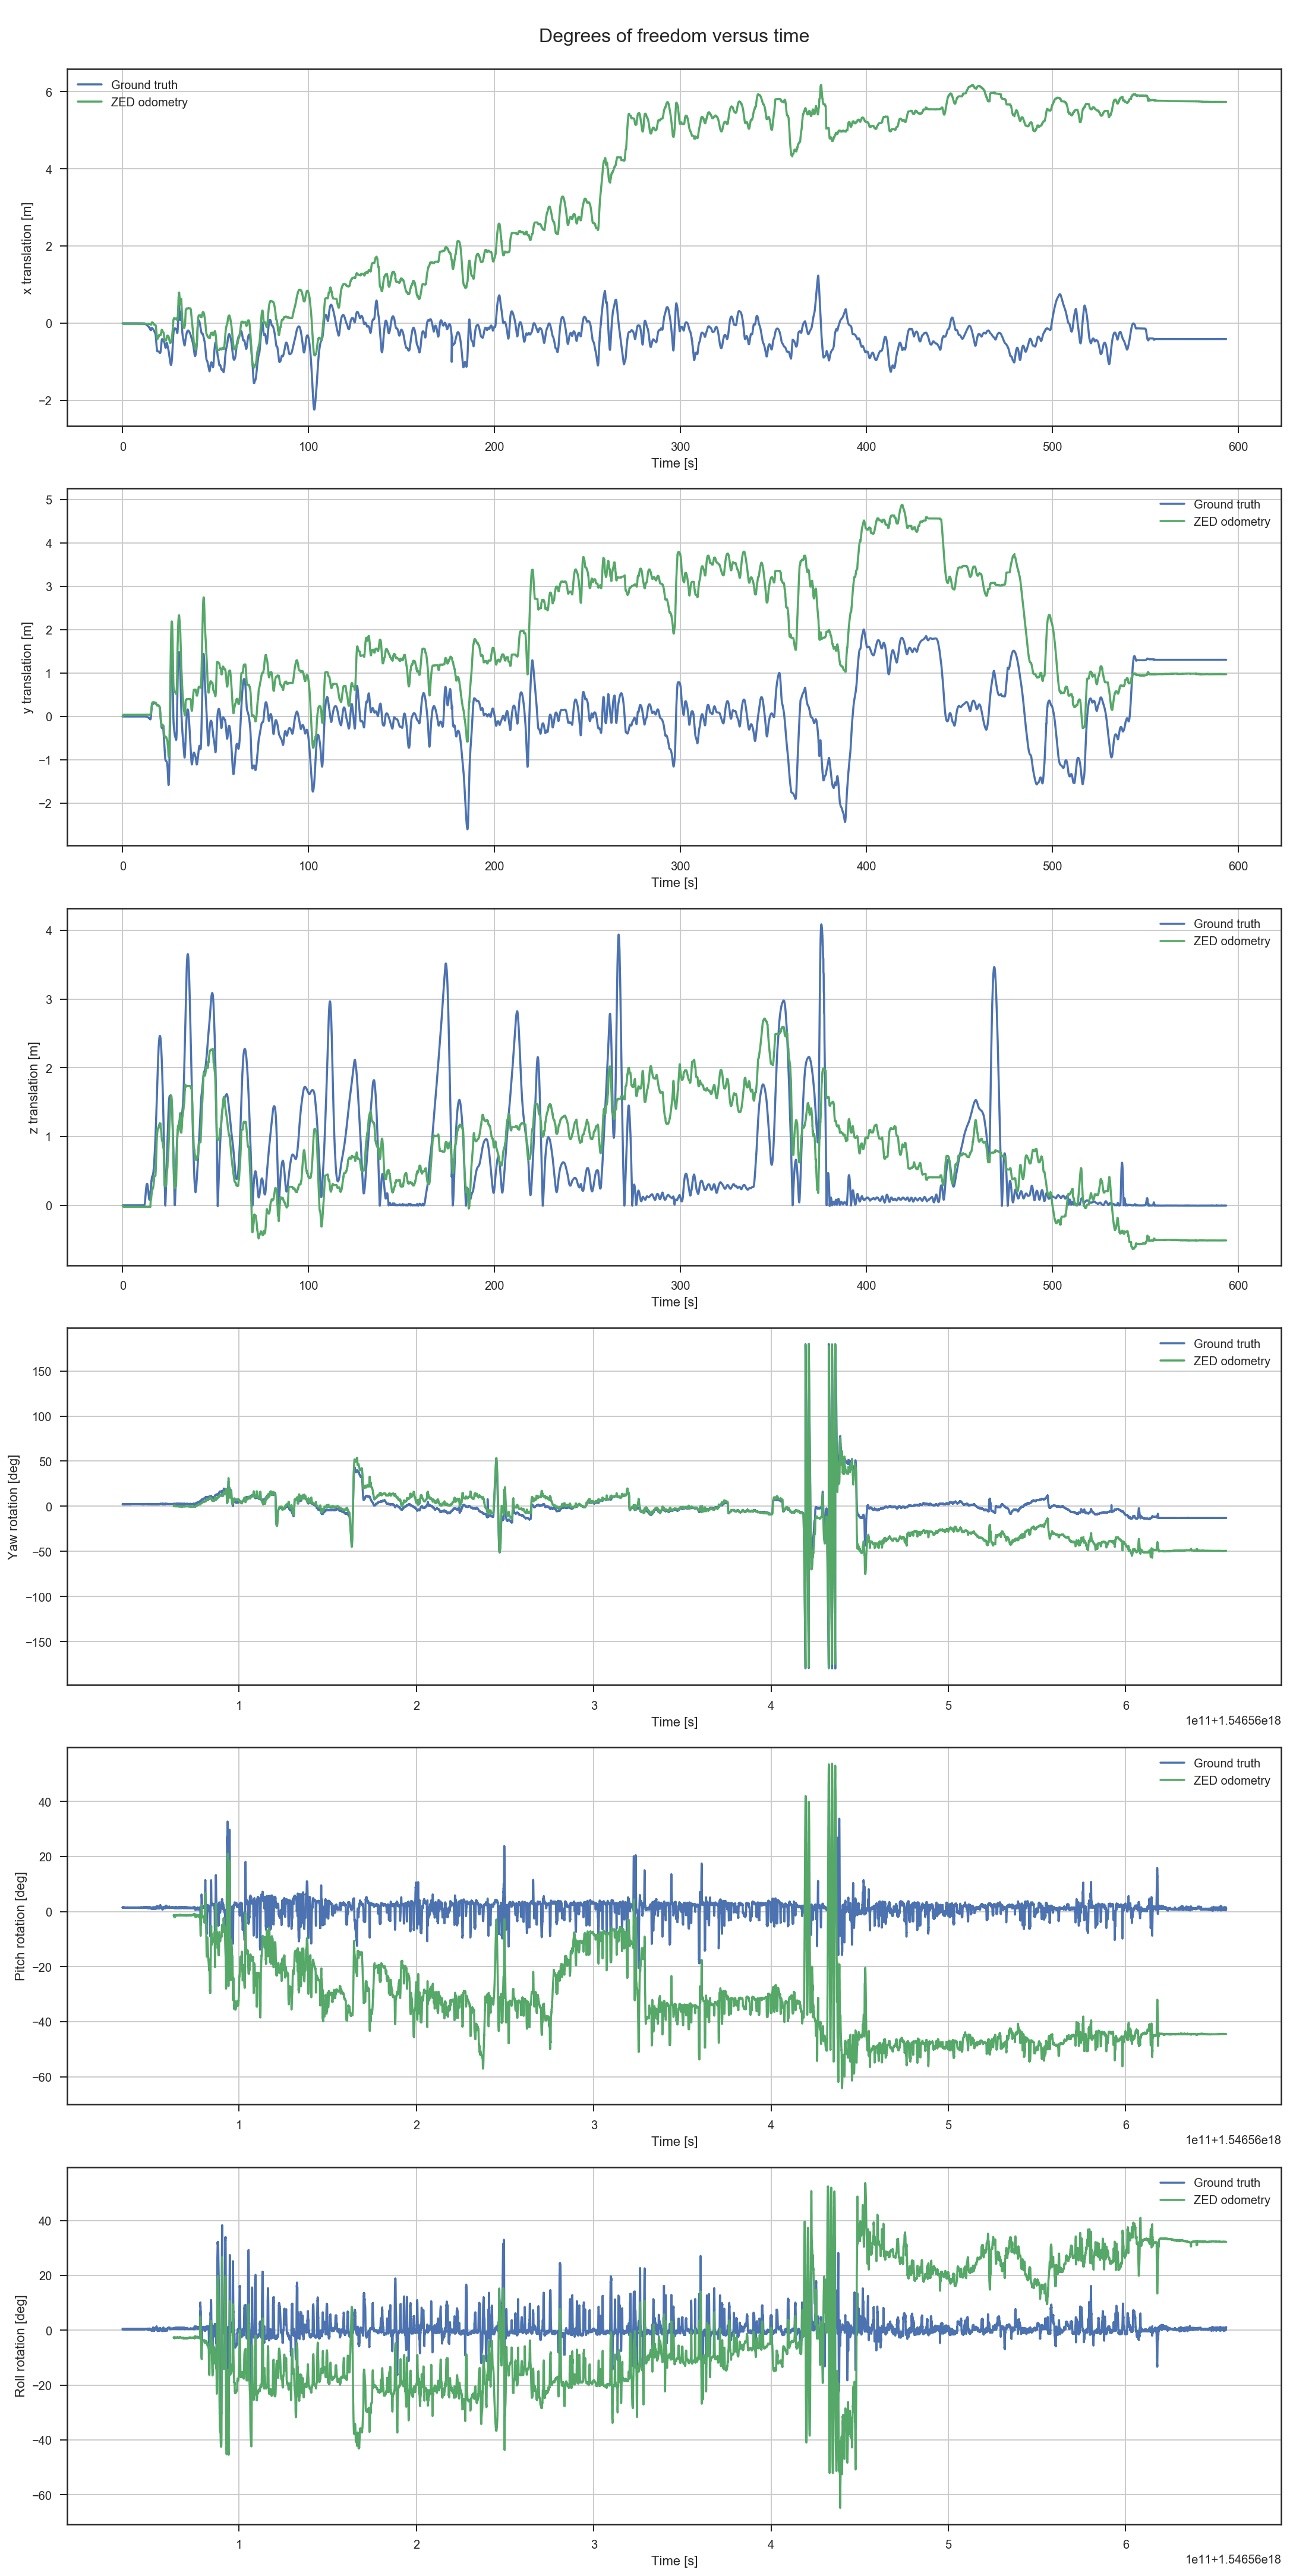

In [56]:
# Plot using matplotlib.
fig, ax = plt.subplots(6, 1,
                       figsize=(15, 30),
                       sharex=False, sharey=False,
                       constrained_layout=True)

label_mcp = 'Ground truth'
label_zed = 'ZED odometry'

ax[0].plot(mcp_x.t, mcp_x.x, label=label_mcp)
ax[0].plot(zed_x.t, zed_x.x, label=label_zed)
ax[0].legend()
ax[0].grid()
ax[0].set_title('\nDegrees of freedom versus time\n', fontsize=16)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('x translation [m]')

ax[1].plot(mcp_y.t, mcp_y.y, label=label_mcp)
ax[1].plot(zed_y.t, zed_y.y, label=label_zed)
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('y translation [m]')

ax[2].plot(mcp_z.t, mcp_z.z, label=label_mcp)
ax[2].plot(zed_z.t, zed_z.z, label=label_zed)
ax[2].legend()
ax[2].grid()
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('z translation [m]')

ax[3].plot(mcp_yaw.t, mcp_yaw.yaw, label=label_mcp)
ax[3].plot(zed_yaw.t, zed_yaw.yaw, label=label_zed)
ax[3].legend()
ax[3].grid()
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Yaw rotation [deg]')

ax[4].plot(mcp_pitch.t, mcp_pitch.pitch, label=label_mcp)
ax[4].plot(zed_pitch.t, zed_pitch.pitch, label=label_zed)
ax[4].legend()
ax[4].grid()
ax[4].set_xlabel('Time [s]')
ax[4].set_ylabel('Pitch rotation [deg]')

ax[5].plot(mcp_roll.t, mcp_roll.roll, label=label_mcp)
ax[5].plot(zed_roll.t, zed_roll.roll, label=label_zed)
ax[5].legend()
ax[5].grid()
ax[5].set_xlabel('Time [s]')
ax[5].set_ylabel('Roll rotation [deg]')

'''
err_x = zed_x.x - mcp_x.x
ax[6].plot(zed_x.t, err_x)
ax[6].grid()
ax[6].set_title('\n\nMeasurement errors versus time\n', fontsize=16)
ax[6].set_xlabel('Time [s]')
ax[6].set_ylabel('Error in x translation [m]')

err_y = zed_y.y - mcp_y.y
ax[7].plot(zed_y.t, err_y)
ax[7].grid()
ax[7].set_xlabel('Time [s]')
ax[7].set_ylabel('Error in y translation [m]')

err_z = zed_z.z - mcp_z.z
ax[8].plot(zed_z.t, err_z)
ax[8].grid()
ax[8].set_xlabel('Time [s]')
ax[8].set_ylabel('Error in z translation [m]')

err_yaw = zed_yaw.yaw - mcp_yaw.yaw
ax[9].plot(zed_yaw.t, err_yaw)
ax[9].grid()
ax[9].set_xlabel('Time [s]')
ax[9].set_ylabel('Error in yaw rotation [deg]')

err_pitch = zed_pitch.pitch - mcp_pitch.pitch
ax[10].plot(zed_pitch.t, err_pitch)
ax[10].grid()
ax[10].set_xlabel('Time [s]')
ax[10].set_ylabel('Error in pitch rotation [deg]')

err_roll = zed_roll.roll - mcp_roll.roll
ax[11].plot(zed_roll.t, err_roll)
ax[11].grid()
ax[11].set_xlabel('Time [s]')
ax[11].set_ylabel('Error in roll rotation [deg]')

err_x.hist(ax=ax[12], bins=50)
ax[12].grid()
ax[12].set_title('\n\nHistograms of the measurement errors\n', fontsize=16)
ax[12].set_xlabel('Error in x translation [m]')
ax[12].set_ylabel('Frequency [-]')

err_y.hist(ax=ax[13], bins=50)
ax[13].grid()
ax[13].set_xlabel('Time [s]')
ax[13].set_xlabel('Error in y translation [m]')
ax[13].set_ylabel('Frequency [-]')

err_z.hist(ax=ax[14], bins=50)
ax[14].grid()
ax[14].set_xlabel('Time [s]')
ax[14].set_xlabel('Error in z translation [m]')
ax[14].set_ylabel('Frequency [-]')

err_yaw.hist(ax=ax[15], bins=50)
ax[15].grid()
ax[15].set_xlabel('Time [s]')
ax[15].set_xlabel('Error in yaw rotation [deg]')
ax[15].set_ylabel('Frequency [-]')

err_pitch.hist(ax=ax[16], bins=50)
ax[16].grid()
ax[16].set_xlabel('Time [s]')
ax[16].set_xlabel('Error in pitch rotation [deg]')
ax[16].set_ylabel('Frequency [-]')

err_roll.hist(ax=ax[17], bins=50)
ax[17].grid()
ax[17].set_xlabel('Time [s]')
ax[17].set_xlabel('Error in roll rotation [deg]')
ax[17].set_ylabel('Frequency [-]')
'''

plt.show()

### Error statistics

##### $x$-translation [m]

In [9]:
print(err_x.abs().describe())

count    9.961000e+03
mean     2.880929e-02
std      1.723228e-02
min      5.866850e-07
25%      1.735407e-02
50%      2.945636e-02
75%      4.230851e-02
max      7.320717e-02
Name: x, dtype: float64


##### $y$-translation [m]

In [10]:
print(err_y.abs().describe())

count    9216.000000
mean        0.019904
std         0.013497
min         0.000002
25%         0.007927
50%         0.018979
75%         0.029389
max         0.064332
Name: y, dtype: float64


##### $z$-translation [m]

In [11]:
print(err_z.abs().describe())

count    5402.000000
mean        0.653556
std         0.400372
min         0.000013
25%         0.384321
50%         0.604298
75%         0.921462
max         1.460764
Name: z, dtype: float64


##### Yaw [deg]

In [12]:
print(err_yaw.abs().describe())

count    6039.000000
mean        1.163386
std         0.774451
min         0.001604
25%         0.542626
50%         1.073326
75%         1.636367
max         4.702737
Name: yaw, dtype: float64


##### Pitch [deg]

In [13]:
print(err_pitch.abs().describe())

count    4228.000000
mean        6.080133
std         6.479675
min         0.001193
25%         2.251471
50%         5.411875
75%         7.822969
max        64.423736
Name: pitch, dtype: float64


##### Roll [deg]

In [14]:
print(err_roll.abs().describe())

count    3772.000000
mean        1.072741
std         1.407386
min         0.000000
25%         0.349369
50%         0.831699
75%         1.460992
max        35.190560
Name: roll, dtype: float64
